# Fig 3 (II) - Quantifying and modelling the effects of sequence features on CDS TE

## Dataset

In [1]:
s = "mm"
stage = "mES"
ASSEMBLY = "GRCm38_ens"

# s = "dr"
# stage = "Shield"
# ASSEMBLY = "Zv9_ens"

# s = "hs"
# stage = "HeLa"
# ASSEMBLY = "GRCh37_ens"

## Imports, parameters and functions

In [2]:
# FILTER PARAMETERS
UTR5_LENGTH_MIN = 25
UTR3_LENGTH_MIN = 25

FPKM_MIN = 0.1
CDS_LENGTH_MIN = 100
CDS_READS_MIN = 1

UORF_LENGTH_MIN = 20
UORF_FROM_TRANSCRIPT_START_MIN = UTR5_LENGTH_MIN
UORF_READS_MIN = 1

UTR5_READS_MIN = 1

ORF_END_TRIM = 10

In [3]:
# IMPORTS
import corebio
import weblogolib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

from Bio import SeqIO
from IPython.display import display, HTML, Markdown, Image
from ast import literal_eval
from numpy import argmax, mean, log10, log2, inf, nan, array, float64, subtract, multiply, divide, sign
from pandas import Panel, DataFrame, Series
from pandas.stats.moments import rolling_mean
from scipy.stats import spearmanr, ks_2samp, pearsonr, linregress, zscore, kendalltau, kde
from scipy.stats.mstats import trimboth
from sklearn.linear_model import Ridge, RidgeCV
from statsmodels.distributions import ECDF
from statsmodels.nonparametric.smoothers_lowess import lowess

%matplotlib inline

In [4]:
pd.options.display.mpl_style = 'default'
pd.options.mode.chained_assignment = None
mpl.rcParams['figure.figsize'] = 8, 6
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.facecolor'] = "#fdfdfd"
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['savefig.dpi'] = 50

In [5]:
C_NT = ("#00d700", "#df1f00", "#0226cc", "#ffb700")
C_UORF = ('#b30000', '#e34a33', '#fc8d59', '#fdbb84', '#fdd49e')
C_CDS = ("#105e47", "#157e5f", "#1b9e77", "#48b192", "#76c4ad")
C_RATIO = "#7570b3"
C_BG = ("#000000", "#525252", "#969696", "#d9d9d9")
C_SP = {"hs": "#97543a", "mm": "#546079", "dr": "#3d7463"}
C_SP_BAR = {"hs": "#fc8d62", "mm": "#8da0cb", "dr": "#66c2a5"}
C_NOBIAS = "#ffd92f"
C_SCATTER = "#737373"
C_TREND = "#e41a1c"
C_TLOC = {"5' UTR": "#d95f02", "CDS start": "#1b9e77", "CDS internal": "#e7298a", "3' UTR": "#e6ab02"}
C_STARTS = ("#276419", "#4d9221", "#7fbc41")
C_STOPS = ("#8e0152", "#c51b7d", "#de77ae")

In [6]:
def scatter_linear_trend(x, y, x_label, y_label, plot_trend=True, corr_table=True):
    data = DataFrame({"x": x, "y": y}).dropna()
    
    plt.figure()
    plt.scatter(data.x, data.y, alpha=0.25, c=C_SCATTER)

    mod = Ridge(normalize=False).fit(zip(*[data.x,]), data.y)
    x1, x2 = (np.percentile(data.x, 2.5), np.percentile(data.x, 97.5))
    y1, y2 = mod.predict([(x1,), (x2,)])
    
    plt.ylim(np.percentile(data.y, 1), np.percentile(data.y, 99))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if plot_trend:
        plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)

    if corr_table:
        to_display = DataFrame(columns=["Correlation\ncoefficient", "p-value"])

        corr, p = pearsonr(data.x, data.y)
        to_display.loc["Pearson linear"] = {"Correlation\ncoefficient": corr,
                                    "p-value": p}
        corr, p = spearmanr(data.x, data.y)
        to_display.loc["Spearman rank"] = {"Correlation\ncoefficient": corr,
                                  "p-value": p}

        display(Markdown(y_label + " against " + x_label))
        display(to_display.applymap('{:,.4g}'.format))
    
    return abs(y2 - y1), sign(y2 - y1)

In [7]:
def flatten(i):
    return [j for k in i for j in k]

def clean(i):
    return i.replace([-inf, inf], nan).dropna()

def z(i):
    return (i - i.mean()) / i.std(ddof=0)

In [8]:
def individual_correlations(parameter_set_names_to_correlate, parameter_sets, data_set_name, data_set):
    to_display = DataFrame(columns=["linear correlation", "p", "fold change over 95% of data"])
    
    colors = flatten([[parameters[i][3] for j in range(len(parameters[i][0]))] for i in parameter_set_names_to_correlate])
    
    for set_name in parameter_set_names_to_correlate:
        for parameter, label, limits, _ in zip(*parameters[set_name]):
            if parameter not in data_set.columns:
                continue

            data = clean(data_set[[parameter, "log2_CDS_TE"]])
            
            corr, p = pearsonr(data[parameter], data.log2_CDS_TE)
            
            plt.figure()
            plt.scatter(data[parameter], data.log2_CDS_TE, alpha=0.25, c=C_SCATTER)
            
            plt.xlabel(label)
            plt.ylabel("log2 CDS TE")
            
            plt.xlim(*limits)
            plt.ylim(-8, 0)
            plt.title(data_set_name)
            mod = Ridge(normalize=False).fit(zip(*[data[parameter],]), data.log2_CDS_TE)
            
            x1, x2 = (np.percentile(data[parameter], 2.5), np.percentile(data[parameter], 97.5))
            y1, y2 = mod.predict([(x1,), (x2,)])
            
            plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)

            to_display.loc[label] = {"linear correlation": corr, "p": p,
                                     "fold change over 95% of data": 2**(y2 - y1)}

    display(Markdown("### Individual correlations with CDS TE, " + data_set_name[:1].lower() + data_set_name[1:]))
    display(to_display.iloc[::-1].applymap('{:,.4g}'.format))
    
    plt.figure(figsize=(6, 0.75 + float(len(to_display)) * .3))
    ax = to_display["fold change over 95% of data"].apply(log2).plot(kind="barh", width=0.9, color=colors)
    ax.set_xlabel("log2 fold change over 95% of data")

In [9]:
def lin_regress_sets_RidgeCV(regressor_sets, parameter_sets, data_set_name, data_set,
                             parameter_to_regress, to_regress_label, limits, limits_coeff):
    
    to_display1 = DataFrame(columns=["Pearson r", "p", "Fold change", "PRESS", "RESS", "n"])
    
    sets_to_regress = list(set(flatten(regressor_sets)))
    regressors = [i + "_Z" for i in flatten([parameters[i][0] for i in sets_to_regress])]
    data = data_set[regressors + [parameter_to_regress]].dropna()
    
    for regressor_set in regressor_sets:
        
        regressors = [i + "_Z" for i in flatten([parameter_sets[i][0] for i in regressor_set])]
        regressor_labels = [i for i in flatten([parameter_sets[i][1] for i in regressor_set])]
        colors = flatten([[parameter_sets[i][3] for j in range(len(parameter_sets[i][0]))] for i in regressor_set])

        mod = RidgeCV(normalize=False, store_cv_values=True).fit(data[regressors], data[parameter_to_regress])
        combined_score = np.sum([data[i].multiply(j) for i, j in zip(regressors, mod.coef_)], axis=0)
        
        plt.figure()
        plt.scatter(combined_score, data[parameter_to_regress], alpha=0.25, c=C_SCATTER)
        plt.xlabel("+".join(regressor_set) + " combined score")
        plt.ylabel(to_regress_label)
        plt.xlim(*limits[0])
        plt.ylim(*limits[1])
        plt.title(data_set_name)

        corr, p = pearsonr(combined_score, data[parameter_to_regress])

        x1, x2 = [np.percentile(combined_score, i) for i in [2.5, 97.5]]
        predicted = mod.predict(data[regressors])
        y1, y2 = [np.percentile(predicted, i) for i in [2.5, 97.5]]
        plt.plot((x1, x2), (y1, y2), c=C_TREND, lw=2)
        
        to_display1.loc[" + ".join(regressor_set)] = {"Pearson r": corr, "p": p,
                                                      "Fold change": 2**(y2-y1),
                                                      "PRESS": sum(mod.cv_values_)[0],
                                                      "RESS": sum((predicted - data[parameter_to_regress]) ** 2),
                                                      "n": len(data[parameter_to_regress])}
        
        display(Markdown(" + ".join(regressor_set) + " sequence features"))
        to_display = DataFrame(columns=["Relative contribution", "per unit 2fold change"])
        for i, label, j in zip(regressors, regressor_labels, mod.coef_):
            to_display.loc[label] = {"Relative contribution": j,
                                     "per unit 2fold change": data_set[i[:-2]].std() * j}
        to_display.index.name = "Sequence feature"
        display(to_display.iloc[::-1].applymap('{:,.4g}'.format))
        
        plt.figure(figsize=(6, 0.75 + float(len(to_display)) * .3))
        ax = to_display["Relative contribution"].plot(kind="barh", width=0.9, color=colors)
        ax.set_xlabel("Relative contribution")
        plt.xlim(*limits_coeff)
        plt.title("CDS TE")
        print
    to_display1.index.name = "Sequence feature set"
    display(to_display1.applymap('{:,.4g}'.format))

In [10]:
def scatter_by_uORF_num(dataset, dataset_label, para_x, para_y,
                        para_x_label, para_y_label, x_limits, y_limits):
    subset_labels = ["1 uORF", "2 uORFs", "3 uORFs", "4+ uORFs"]
    plt.figure()
    data = dataset[[para_x, para_y]]
    data["num_uORF"] = dataset.num_uORFs.apply(lambda x: min(x, 4))
    data = clean(data)

    cmap = mpl.colors.ListedColormap(C_UORF[:-1])

    fig, ax = plt.subplots()
    fig1 = ax.scatter(data[para_x], data[para_y], c=data.num_uORF, s=15,
                      cmap=cmap, vmax=data.num_uORF.max(), alpha=0.3)

    for num_uORF, color in zip([1, 2, 3, 4], C_UORF[:-1]):
        sns.kdeplot(data[para_x][data.num_uORF == num_uORF], data[para_y][data.num_uORF == num_uORF],
                    n_levels=5, cmap=None, colors=color, linewidths=[0,3,0,0,0], alpha=1)
        
    
    sns.kdeplot(data[para_x], data[para_y], n_levels=5, cmap=None,
                colors=C_SCATTER, linewidths=[0,3,0,0,0], alpha=1)

    cbar = fig.colorbar(fig1, ticks=[np.arange(0.4, 5, 0.8)])
    cbar.ax.set_yticklabels(subset_labels)

    plt.xlabel(para_x_label)
    plt.ylabel(para_y_label)
    plt.legend(loc="upper left")
    plt.xlim(*x_limits)
    plt.ylim(*y_limits)
    plt.title(dataset_label)
    
    to_display = DataFrame(columns=["Correlation\ncoefficient", "p-value"])

    for num_uORF, label in zip((1, 2, 3, 4), subset_labels):
        corr, p = pearsonr(data[para_x][data.num_uORF == num_uORF],
                           data[para_y][data.num_uORF == num_uORF])
        to_display.loc[label] = {"Correlation\ncoefficient": corr,
                                                   "p-value": p}
    corr, p = pearsonr(data[para_x], data[para_y])
    to_display.loc["All"] = {"Correlation\ncoefficient": corr,
                                "p-value": p}
    display(Markdown(para_y_label + " against " + para_x_label))
    display(to_display.applymap('{:,.4g}'.format))

## Reading in ORF characteristics data

In [11]:
DATA_DIR = "./data/" + s + "/"
ANNOTATIONS_DIR = "./annotations/"

In [12]:
CONVERTERS = {i:literal_eval for i in ("uORFs_reads", "uORFs_length", "uORFs_wrent_score", "uORFs_urent_score",
                                       "uORFs_wrent_seq", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R",
                                       "uORFs_start_pos_wrt_tss", "uORFs_end_pos_wrt_CDS",
                                       "ORFs_wrent_score", "ORFs_urent_score", "ORFs_wrent_seq",
                                       "ORFs_sec_struct_EFE_L", "ORFs_sec_struct_EFE_R")}

In [13]:
stage_species = {"mES": "mm", "HeLa": "hs", "Shield": "dr"}
mean_ssefes = pd.read_table(DATA_DIR + stage_species[stage] + "_mean_ssefes.df", sep="\t", index_col=[0])

In [14]:
windows = [25, 30, 35, 40]
df_main = pd.read_csv(DATA_DIR + stage + "_main.df", index_col="Transcript", sep="\t", converters=CONVERTERS)
for window in windows:
    for pos in ("UTR5", "CDS"):
        field = pos + "_mean_ssefe_" + str(window)
        df_main[field] = mean_ssefes[field][mean_ssefes.index.isin(df_main.index)]
        df_main[field + "_Z"] = z(df_main[field])

In [15]:
df_main_filtered = df_main[(df_main.UTR5_length >= UTR5_LENGTH_MIN) &
                           (df_main.UTR3_length >= UTR3_LENGTH_MIN) &
                           (df_main.Gene_Expression_FPKM >= FPKM_MIN) &
                           (df_main.CDS_length >= CDS_LENGTH_MIN) &
                           (df_main.CDS_reads >= CDS_READS_MIN) &
                           (df_main.UTR5_reads_trunc >= UTR5_READS_MIN)]

In [16]:
df_main_filtered["CDS_density"] = df_main_filtered.CDS_reads / \
                                  df_main_filtered.CDS_length.subtract(ORF_END_TRIM)

df_main_filtered["CDS_TE"] = df_main_filtered.CDS_density / \
                             df_main_filtered.Gene_Expression_FPKM

df_main_filtered["log2_CDS_density"] = log2(df_main_filtered.CDS_density)

df_main_filtered["log2_CDS_TE"] = log2(df_main_filtered.CDS_TE)

df_main_filtered["num_uORFs"] = df_main_filtered.num_uORFs.replace([0], 0.1)

df_main_filtered["num_uORFs_density"] = df_main_filtered.num_uORFs.apply(float) / \
                                        df_main_filtered.UTR5_length

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    df_main_filtered["log_" + parameter] = clean(log10(df_main_filtered[parameter].apply(float)))
    df_main_filtered["log_" + parameter + "_Z"] = z(df_main_filtered["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R",
                  "UTR5_GC", "CDS_GC", "num_uORFs"):
    df_main_filtered[parameter + "_Z"] = z(df_main_filtered[parameter])

## Restricting uORF sequence feature effect analyses to transcripts with only one non-overlapping uORF

In [17]:
no_uORFs = df_main_filtered[df_main_filtered.num_uORFs < 1]
with_uORFs = df_main_filtered[df_main_filtered.num_uORFs >= 1]
one_uORF = df_main_filtered[df_main_filtered.num_uORFs == 1]
two_uORF = df_main_filtered[df_main_filtered.num_uORFs == 2]
three_uORF = df_main_filtered[df_main_filtered.num_uORFs == 3]

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    no_uORFs["log_" + parameter + "_Z"] = z(no_uORFs["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    no_uORFs[parameter + "_Z"] = z(no_uORFs[parameter])

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    with_uORFs["log_" + parameter + "_Z"] = z(with_uORFs["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    with_uORFs[parameter + "_Z"] = z(with_uORFs[parameter])

In [18]:
# Creates set of 1 non-overlapping uORF
one_non_overlapping_uORF = df_main_filtered[(df_main_filtered.num_uORFs == 1)]   # 1 uORF

# Since set has only transcripts with 1 uORF, "singularize" some columns of data
for variable in ("uORFs_reads", "uORFs_length", "uORFs_wrent_score", "uORFs_urent_score",
                 "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R", "uORFs_start_pos_wrt_tss",
                 "uORFs_end_pos_wrt_CDS"):
    one_non_overlapping_uORF[variable] = one_non_overlapping_uORF[variable].apply(lambda x:x[0])

# Filter set for non-overlapping uORF, with uORFs of minimum length, reads and distance from transcript start
one_non_overlapping_uORF = one_non_overlapping_uORF[\
    (one_non_overlapping_uORF.uORFs_end_pos_wrt_CDS < 0) &
    (one_non_overlapping_uORF.uORFs_reads >= UORF_READS_MIN) &
    (one_non_overlapping_uORF.uORFs_length >= UORF_LENGTH_MIN) &
    (one_non_overlapping_uORF.uORFs_start_pos_wrt_tss >= UORF_FROM_TRANSCRIPT_START_MIN)]
print "Number of one non-overlapping uORF Transcripts = %d" % len(one_non_overlapping_uORF)

# Calculate uORF TEs for set
one_non_overlapping_uORF["uORF_TE"] = one_non_overlapping_uORF.apply(lambda x: float64(x.uORFs_reads) \
                                                                               / (x.uORFs_length - ORF_END_TRIM) \
                                                                               / x.Gene_Expression_FPKM, axis=1)

Number of one non-overlapping uORF Transcripts = 750


In [19]:
one_non_overlapping_uORF["uORF_CDS_log_dist"] = one_non_overlapping_uORF.uORFs_end_pos_wrt_CDS.apply(lambda x:log10(-x))

for parameter in ("uORFs_length", "uORFs_start_pos_wrt_tss"):
    one_non_overlapping_uORF["log_" + parameter] = log10(one_non_overlapping_uORF[parameter].apply(float))
    one_non_overlapping_uORF["log_" + parameter + "_Z"] = z(one_non_overlapping_uORF["log_" + parameter])

for parameter in ("uORFs_wrent_score", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R", "uORF_CDS_log_dist"):
    one_non_overlapping_uORF[parameter + "_Z"] = z(one_non_overlapping_uORF[parameter])

for parameter in ("CDS_TE", "CDS_length", "UTR5_length", "Gene_Expression_FPKM", "num_uORFs_density"):
    one_non_overlapping_uORF["log_" + parameter + "_Z"] = z(one_non_overlapping_uORF["log_" + parameter])

for parameter in ("CDS_wrent_score", "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "UTR5_GC", "CDS_GC", "num_uORFs"):
    one_non_overlapping_uORF[parameter + "_Z"] = z(one_non_overlapping_uORF[parameter])

## Figures

### Integrating various sequence features in linear models

In [20]:
parameters = {"CDS": (("CDS_wrent_score", 
                       "CDS_sec_struct_EFE_L", "CDS_sec_struct_EFE_R", "CDS_mean_ssefe_35"),
                      ("CDS WRENT score", 
                       "CDS start sec struct EFE left", "CDS start sec struct EFE right", "CDS mean sec struct EFE"),
                      ((-8, 8), (-20, 0), (-20, 0), (-10, -4)),
                      C_TLOC["CDS start"]),
              "uORF": (("uORFs_wrent_score", "uORFs_sec_struct_EFE_L", "uORFs_sec_struct_EFE_R",
                        "uORF_CDS_log_dist", "log_uORFs_length", "log_uORFs_start_pos_wrt_tss"),
                       ("uORF WRENT score", "uORF start sec struct EFE left", "uORF start sec struct EFE right",
                        "uORF-CDS log distance", "log uORF length"),#, "log uORF start pos wrt tss"),
                       ((-8, 8), (-20, 0), (-20, 0), (0, 3), (1.4, 3)),#, (1, 3)),
                       C_UORF[0]),
              "5' leader": (("log_UTR5_length", "UTR5_mean_ssefe_35", "log_num_uORFs_density"),
                            ("5' leader log10 length", "5' leader mean sec struct EFE", "log10 uORF density"),
                            ((1.4, 3), (-16, -4), (-3.5, -1.5)),
                            C_TLOC["5' UTR"]),
              "5' leader (fixed uORFs)": (("log_UTR5_length", "UTR5_mean_ssefe_35"),
                            ("5' leader log10 length", "5' leader mean sec struct EFE"),
                            ((1.4, 3), (-16, -4)),
                            C_TLOC["5' UTR"]),
#               "5' leader": (("log_UTR5_length", "UTR5_mean_ssefe_35"),
#                             ("5' leader log10 length", "5' leader mean sec struct EFE"),
#                             ((1.4, 3), (-16, -4)),
#                             C_TLOC["5' UTR"]),
              "others": (("log_Gene_Expression_FPKM",),
                         ("Gene Expression (log10 FPKM)",),
                         ((-1, 3),),
                         C_BG[1])}

**Supp Fig 8a, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for all filtered transcripts

### Individual correlations with CDS TE, all filtered transcripts

linear correlation           p  \
Gene Expression (log10 FPKM)              -0.1349   2.821e-42   
log10 uORF density                        -0.1967   1.015e-88   
5' leader mean sec struct EFE              0.1171   9.716e-32   
5' leader log10 length                    -0.1067   5.752e-27   
CDS mean sec struct EFE                    0.2386  7.765e-129   
CDS start sec struct EFE right              0.103   3.088e-25   
CDS start sec struct EFE left              0.1069   4.518e-27   
CDS WRENT score                            0.1533   3.503e-54   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.5764  
log10 uORF density                                   0.5096  
5' leader mean sec struct EFE                         1.591  
5' leader log10 length                               0.6481  
CDS mean sec struct EFE                               2.534  
CDS start sec struct EFE right                        1.507  
CDS start sec struct EFE left                         1.537  
CDS WRENT score                                        1.85

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
c:\Anaconda2\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


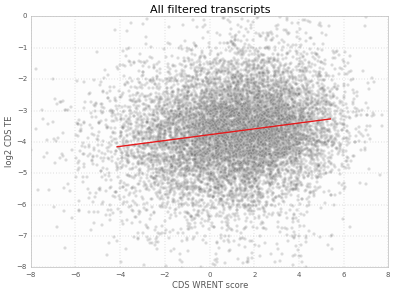

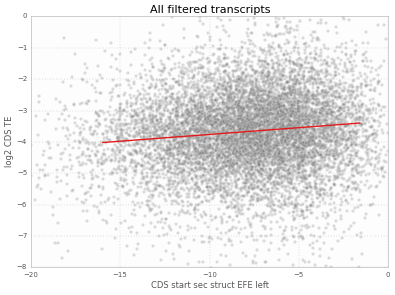

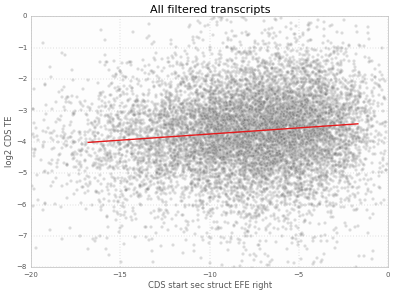

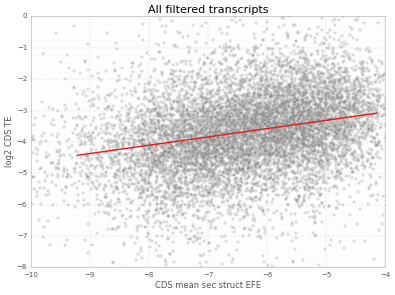

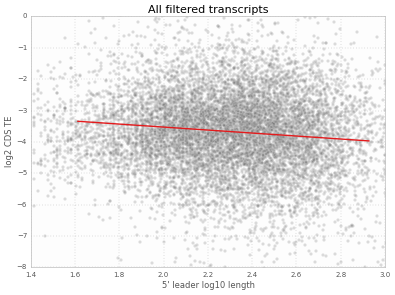

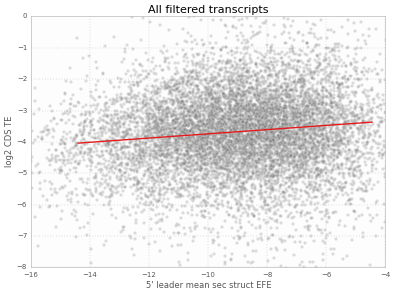

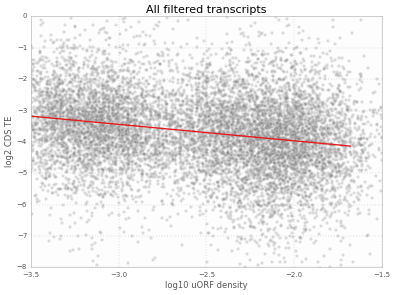

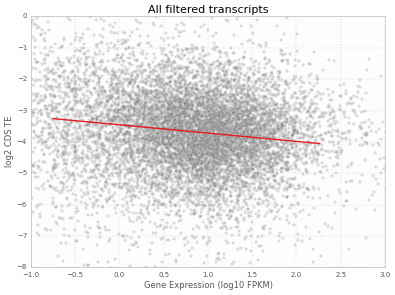

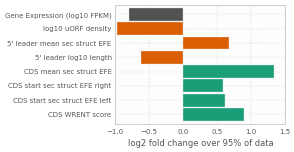

In [21]:
individual_correlations(("CDS", "5' leader", "others"), parameters, "All filtered transcripts", df_main_filtered)

**Supp Fig 8a, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for transcripts with uORFs

### Individual correlations with CDS TE, filtered transcripts with uORFs

linear correlation          p  \
Gene Expression (log10 FPKM)              -0.1335   4.89e-24   
log10 uORF density                       -0.09506  6.662e-13   
5' leader mean sec struct EFE              0.1196  1.532e-19   
5' leader log10 length                   -0.04852  0.0002506   
CDS mean sec struct EFE                    0.2634  1.095e-90   
CDS start sec struct EFE right             0.1122  2.091e-17   
CDS start sec struct EFE left              0.1101  8.356e-17   
CDS WRENT score                             0.134  3.217e-24   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.5902  
log10 uORF density                                   0.6926  
5' leader mean sec struct EFE                          1.59  
5' leader log10 length                               0.8242  
CDS mean sec struct EFE                                2.74  
CDS start sec struct EFE right                        1.552  
CDS start sec struct EFE left                         1.532  
CDS WRENT score                                       1.699

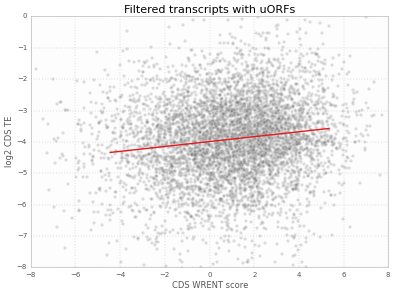

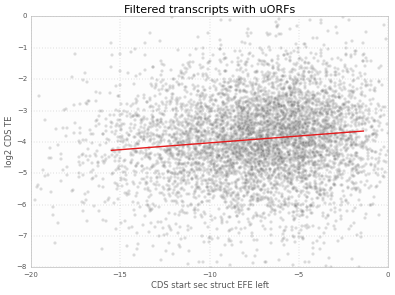

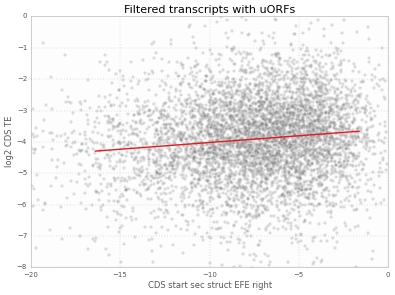

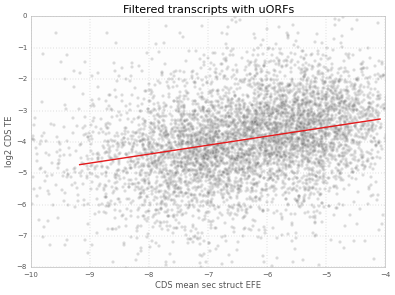

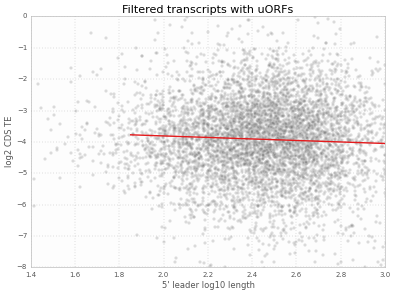

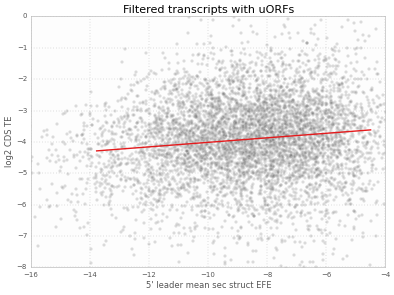

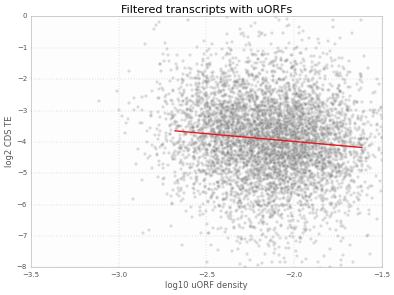

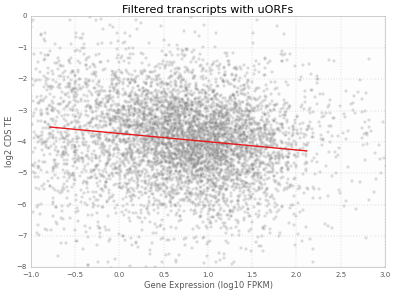

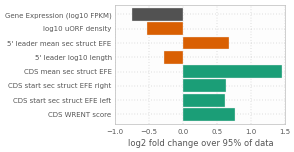

In [22]:
individual_correlations(("CDS", "5' leader", "others"), parameters, "Filtered transcripts with uORFs", with_uORFs)

**Supp Fig 8g, Supp Table 2**: Verifying correlation of individual CDS sequence features to CDS TE for transcripts with no uORFs

### Individual correlations with CDS TE, filtered transcripts without uORFs

linear correlation          p  \
Gene Expression (log10 FPKM)              -0.2152  1.918e-47   
5' leader mean sec struct EFE              0.1858  1.466e-34   
5' leader log10 length                    0.03289    0.02879   
CDS mean sec struct EFE                    0.2259  1.152e-50   
CDS start sec struct EFE right             0.1416  3.143e-21   
CDS start sec struct EFE left              0.1726  7.161e-31   
CDS WRENT score                             0.154  7.241e-25   

                               fold change over 95% of data  
Gene Expression (log10 FPKM)                         0.4102  
5' leader mean sec struct EFE                         2.078  
5' leader log10 length                                1.142  
CDS mean sec struct EFE                               2.352  
CDS start sec struct EFE right                        1.749  
CDS start sec struct EFE left                         1.983  
CDS WRENT score                                       1.828

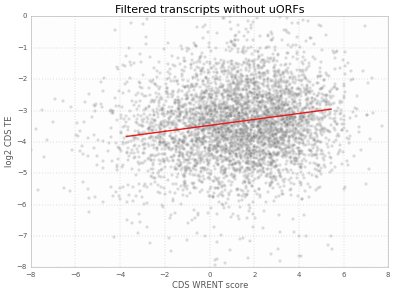

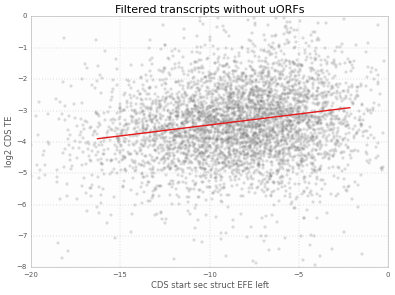

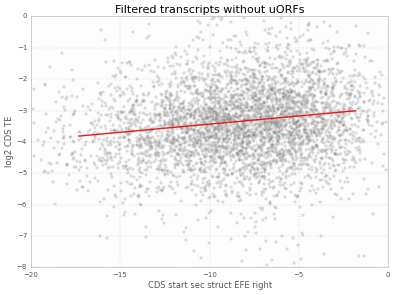

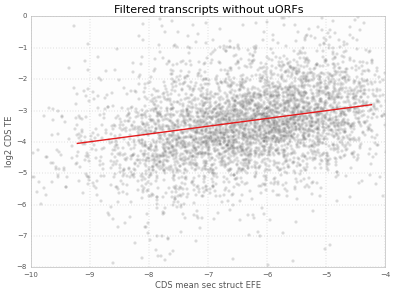

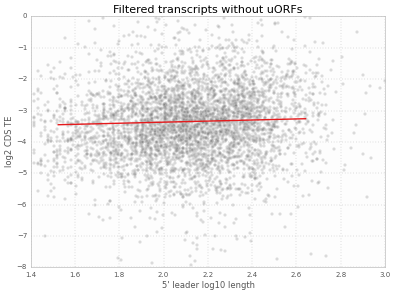

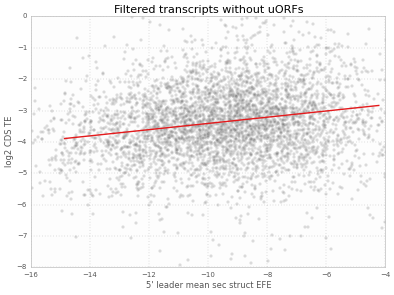

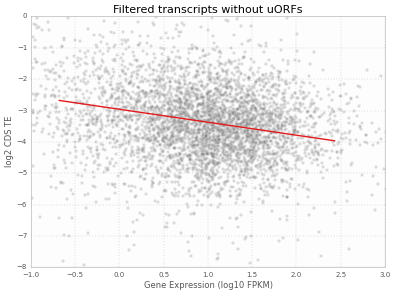

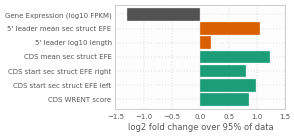

In [23]:
individual_correlations(("CDS", "5' leader (fixed uORFs)", "others"), parameters, "Filtered transcripts without uORFs", no_uORFs)

#### Integrating various sequence features in linear model for CDS TE

Linear modelling of uORF repressiveness with uORF, CDS and 5' leader sequence features. Scatter plots show the relationship of uORF repressiveness to a combined score integrating the various sequence features, while the red line indicates the regression (ridge) line; the relative contributions of individual sequence features is shown in the bar graphs below.

The results of using various sequence feature sets to model uORF repressiveness is summarized in a table, comparing the linear correlation and prediction errors (using the predicted residual sum of squares or PRESS statistic).

**Fig 3f-g, Table 1, Supp Fig 7c-h**: Transcripts with one non-overlapping uORF

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.3295                0.4365
CDS start sec struct EFE right                0.1038                0.4143
CDS start sec struct EFE left                0.09175                0.3587
CDS WRENT score                               0.1149                0.2794

CDS + uORF sequence features

Relative contribution per unit 2fold change
Sequence feature                                                           
log uORF length                              -0.05674              -0.01495
uORF-CDS log distance                          0.2081                0.1053
uORF start sec struct EFE right                0.1267                0.5473
uORF start sec struct EFE left                0.08178                0.3259
uORF WRENT score                              -0.1238               -0.3426
CDS mean sec struct EFE                        0.3314                0.4389
CDS start sec struct EFE right                0.09646                0.3851
CDS start sec struct EFE left                 0.05035                0.1968
CDS WRENT score                                0.1211                0.2944

CDS + 5' leader (fixed uORFs) sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
5' leader mean sec struct EFE                 0.2842                  0.67
5' leader log10 length                        0.1784               0.03759
CDS mean sec struct EFE                        0.354                0.4688
CDS start sec struct EFE right               0.06757                0.2698
CDS start sec struct EFE left               0.009555               0.03735
CDS WRENT score                               0.1244                0.3024

CDS + 5' leader (fixed uORFs) + uORF sequence features

Relative contribution per unit 2fold change
Sequence feature                                                           
log uORF length                               -0.1275              -0.03361
uORF-CDS log distance                         0.08422               0.04263
uORF start sec struct EFE right               0.04339                0.1875
uORF start sec struct EFE left               0.005385               0.02146
uORF WRENT score                              -0.1178                -0.326
5' leader mean sec struct EFE                  0.2367                 0.558
5' leader log10 length                         0.2071               0.04364
CDS mean sec struct EFE                         0.343                0.4542
CDS start sec struct EFE right                 0.0762                0.3042
CDS start sec struct EFE left                  0.0115               0.04494
CDS WRENT score                                0.1234                   0.3

Pearson r          p Fold change  PRESS  \
Sequence feature set                                                           
CDS                                     0.3468  1.292e-22       3.175  1,103   
CDS + uORF                               0.421  1.418e-33       4.227  1,047   
CDS + 5' leader (fixed uORFs)           0.4148  1.499e-32       4.099  1,043   
CDS + 5' leader (fixed uORFs) + uORF    0.4421  3.054e-37       4.337  1,029   

                                       RESS    n  
Sequence feature set                              
CDS                                   1,089  750  
CDS + uORF                            1,019  750  
CDS + 5' leader (fixed uORFs)         1,025  750  
CDS + 5' leader (fixed uORFs) + uORF  996.2  750

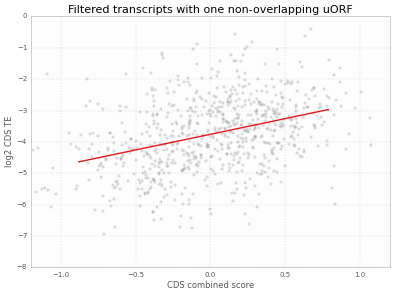

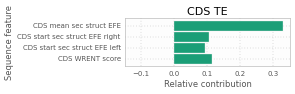

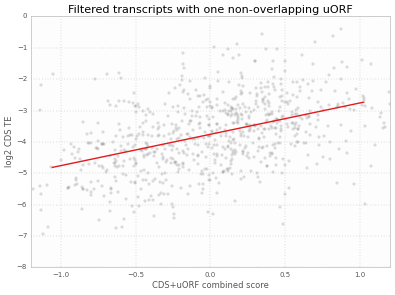

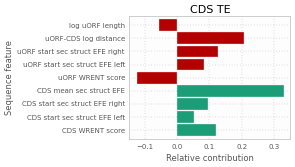

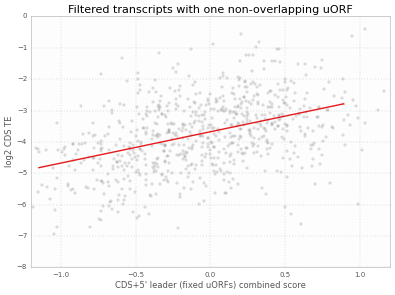

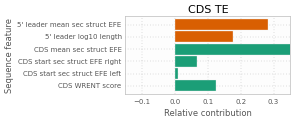

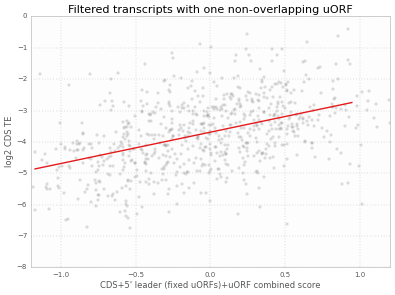

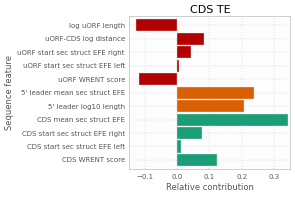

In [24]:
opt = ["5' leader (fixed uORFs)", "uORF"]
# opt = ["5' leader", "uORF"]
permutes = [[i, j] for i in (False, True) for j in (False, True)]
regressor_sets = [["CDS",] + [opt[i] for i, j in enumerate(permute) if j] for permute in permutes]

lin_regress_sets_RidgeCV(regressor_sets, parameters, "Filtered transcripts with one non-overlapping uORF",
                         one_non_overlapping_uORF, "log2_CDS_TE", "log2 CDS TE", ((-1.2, 1.2), (-8, 0)), (-0.15, 0.35))

**Supp Fig S8b-c, e-f, h-i, Supp Table 3**: All filtered transcripts, transcripts with uORFs, transcripts without uORFs

**All filtered transcripts**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.3148                0.4167
CDS start sec struct EFE right               0.02677                0.1044
CDS start sec struct EFE left                0.07202                0.2649
CDS WRENT score                               0.1812                 0.444

CDS + 5' leader sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
log10 uORF density                           -0.3194               -0.1778
5' leader mean sec struct EFE                  0.219                0.5602
5' leader log10 length                       -0.1382              -0.04598
CDS mean sec struct EFE                       0.3152                0.4173
CDS start sec struct EFE right               0.03387                0.1321
CDS start sec struct EFE left                0.05854                0.2154
CDS WRENT score                               0.1525                0.3736

Pearson r          p Fold change      PRESS       RESS  \
Sequence feature set                                                          
CDS                     0.2756  5.91e-173       2.985  1.991e+04  1.989e+04   
CDS + 5' leader         0.3769          0       4.349   1.85e+04  1.847e+04   

                          n  
Sequence feature set         
CDS                   9,954  
CDS + 5' leader       9,954

**Filtered transcripts with uORFs**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.3456                0.4618
CDS start sec struct EFE right               0.03102                0.1178
CDS start sec struct EFE left                0.05419                0.1987
CDS WRENT score                               0.1492                0.3724

CDS + 5' leader sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
log10 uORF density                           -0.2788              -0.07725
5' leader mean sec struct EFE                 0.2546                0.6125
5' leader log10 length                       -0.1961               -0.0575
CDS mean sec struct EFE                       0.3406                 0.455
CDS start sec struct EFE right               0.02808                0.1067
CDS start sec struct EFE left                0.02476               0.09081
CDS WRENT score                               0.1414                0.3529

Pearson r           p Fold change      PRESS       RESS  \
Sequence feature set                                                           
CDS                     0.2874   2.44e-108       3.055  1.098e+04  1.096e+04   
CDS + 5' leader         0.3489  3.973e-162        3.92  1.052e+04  1.049e+04   

                          n  
Sequence feature set         
CDS                   5,673  
CDS + 5' leader       5,673

**Filtered transcripts without uORFs**

CDS sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
CDS mean sec struct EFE                       0.2759                0.3604
CDS start sec struct EFE right               0.06276                0.2498
CDS start sec struct EFE left                 0.1748                0.6311
CDS WRENT score                               0.1637                0.3885

CDS + 5' leader (fixed uORFs) sequence features

Relative contribution per unit 2fold change
Sequence feature                                                          
5' leader mean sec struct EFE                 0.2145                0.5761
5' leader log10 length                       0.05188               0.01452
CDS mean sec struct EFE                       0.2863                 0.374
CDS start sec struct EFE right               0.03951                0.1572
CDS start sec struct EFE left                 0.1002                0.3617
CDS WRENT score                               0.1639                 0.389

Pearson r           p Fold change  PRESS   RESS  \
Sequence feature set                                                            
CDS                              0.2948   1.383e-86       3.078  8,058  8,040   
CDS + 5' leader (fixed uORFs)    0.3248  9.747e-106       3.474  7,903  7,876   

                                   n  
Sequence feature set                  
CDS                            4,281  
CDS + 5' leader (fixed uORFs)  4,281

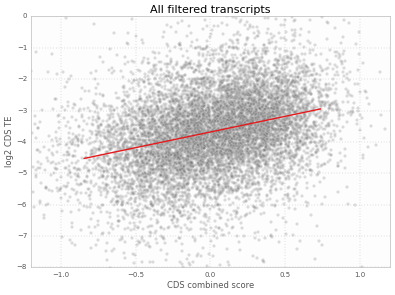

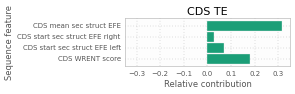

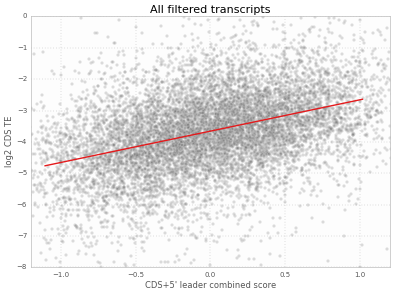

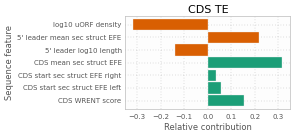

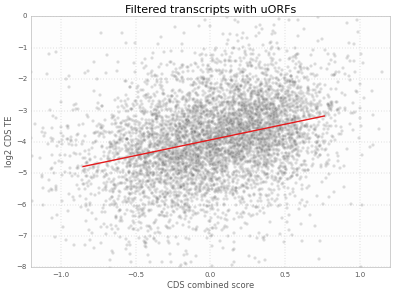

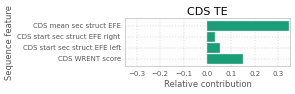

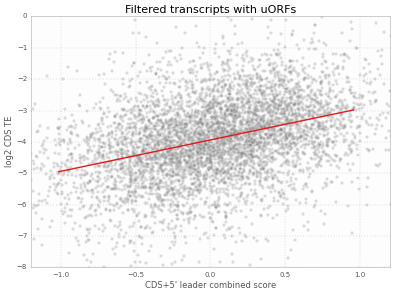

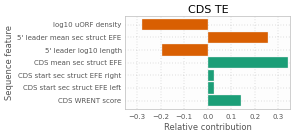

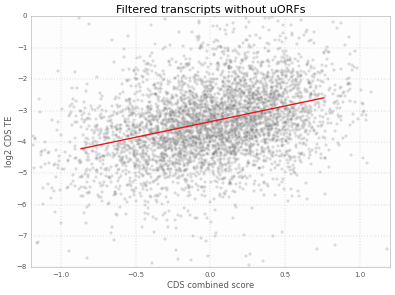

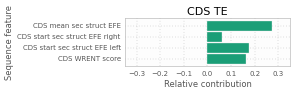

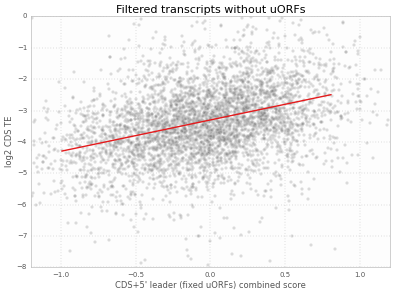

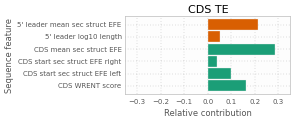

In [25]:
for t_set, t_set_label, UTR5_type in zip((df_main_filtered, with_uORFs, no_uORFs),
                                         ("All filtered transcripts",
                                          "Filtered transcripts with uORFs",
                                          "Filtered transcripts without uORFs"),
                                         ("5' leader", "5' leader", "5' leader (fixed uORFs)")):
    display(Markdown("**" + t_set_label + "**"))
    lin_regress_sets_RidgeCV([["CDS",], ["CDS", UTR5_type]], parameters, t_set_label,
                             t_set, "log2_CDS_TE", "log2 CDS TE", ((-1.2, 1.2), (-8, 0)), (-0.35, 0.35))

#### Tracking correlations amongst 5' leader sequence features

**Supp Fig S14a:** Correlations between 5' leader GC content, density of uORFs and mean secondary structure EFE

log10 density of uORFs  GC content  \
log10 density of uORFs                1.000000   -0.345944   
GC content                           -0.345944    1.000000   
Mean sec struct EFE                   0.242208   -0.875821   

                        Mean sec struct EFE  
log10 density of uORFs             0.242208  
GC content                        -0.875821  
Mean sec struct EFE                1.000000

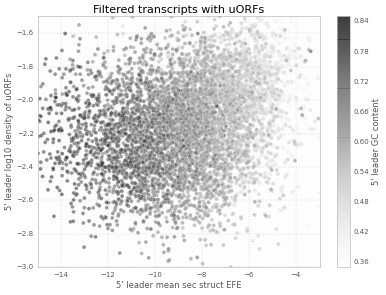

In [26]:
parameters = ["UTR5_GC", "UTR5_mean_ssefe_35"]
data = clean(with_uORFs[["log_num_uORFs_density",] + parameters])

ax = plt.scatter(data.UTR5_mean_ssefe_35, data.log_num_uORFs_density, c=data.UTR5_GC,
                 vmin=0.35, vmax=0.85, cmap="Greys", s=30, alpha=0.5)

plt.xlim(-15, -3)
plt.xlabel("5' leader mean sec struct EFE")
plt.ylim(-3, -1.5)
plt.ylabel("5' leader log10 density of uORFs")
plt.title("Filtered transcripts with uORFs")
plt.colorbar(ax, label="5' leader GC content")

data.columns = ["log10 density of uORFs", "GC content", "Mean sec struct EFE"]
data.corr()

Individual correlations between 5' leader GC content, density of uORFs and mean secondary structure EFE

5' leader log10 uORF density against 5' leader GC content

Correlation\ncoefficient     p-value
Pearson linear                  -0.3459  3.294e-159
Spearman rank                   -0.3517  7.505e-165

5' leader log10 uORF density against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
Pearson linear                   0.2422  1.556e-76
Spearman rank                    0.2671  2.732e-93

5' leader mean sec struct EFE against 5' leader GC content

Correlation\ncoefficient p-value
Pearson linear                  -0.8758       0
Spearman rank                   -0.8791       0

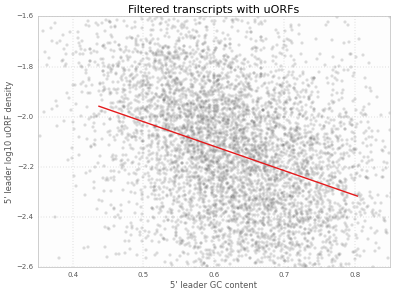

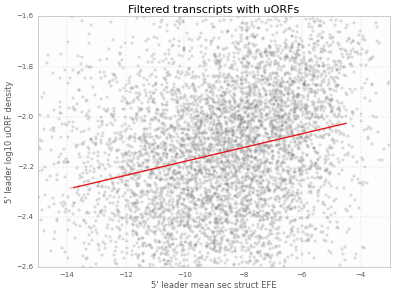

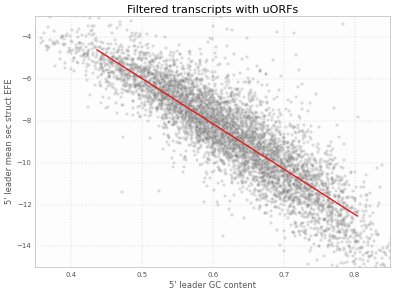

In [27]:
parameters = ["UTR5_GC", "UTR5_mean_ssefe_35"]
data = clean(with_uORFs[["log_num_uORFs_density",] + parameters])

for parameter, parameter_label, limits in zip(parameters,
                                              ("5' leader GC content", "5' leader mean sec struct EFE"),
                                              ((0.35, 0.85), (-15, -3))):
    
    scatter_linear_trend(data[parameter], data.log_num_uORFs_density,
                         parameter_label, "5' leader log10 uORF density")
    plt.xlim(*limits)
    plt.ylim(-2.6, -1.6)
    plt.title("Filtered transcripts with uORFs")

scatter_linear_trend(data.UTR5_GC, data.UTR5_mean_ssefe_35,
                     "5' leader GC content", "5' leader mean sec struct EFE")
plt.xlim(0.35, 0.85)
plt.ylim(-15, -3)
plt.title("Filtered transcripts with uORFs")

**Supp Fig S14b:** Correlations between select sequence parameters, subsetted by number of uORFs per transcripts.

In [28]:
parameters = DataFrame({"log_CDS_TE": {"label": "log10 CDS TE",
                                       "limits": (-2.5, 0)},
                        "log_UTR5_TE": {"label": "log10 5' leader TE",
                                        "limits": (-3.5, 0)},
                        "log_CDS_density": {"label": "log10 CDS RP read density",
                                            "limits": (-2.5, 1.5)},
                        "log_UTR5_density": {"label": "log10 5' leader RP read density",
                                             "limits": (-3, 1)},
                        "log_Gene_Expression_FPKM": {"label": "log10 gene expression (FPKM)",
                                                     "limits": (-1, 2.5)},
                        "log_UTR5_length": {"label": "log10 5' leader length",
                                            "limits": (1.8, 3)},
                        "log_num_uORFs_density": {"label": "log10 5' leader density of uORFs",
                                                  "limits": (-3, -1.5)},
                        "UTR5_GC": {"label": "5' leader GC content",
                                    "limits": (0.35, 0.85)},
                        "UTR5_mean_ssefe_35": {"label": "5' leader mean sec struct EFE",
                                               "limits": (-16, -4)}})

c:\Anaconda2\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
c:\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


log10 5' leader length against 5' leader GC content

Correlation\ncoefficient    p-value
1 uORF                     0.1203  3.007e-09
2 uORFs                    0.1516  1.519e-07
3 uORFs                    0.2433  9.952e-12
4+ uORFs                  0.02375     0.3878
All                       -0.1189  2.328e-19

5' leader mean sec struct EFE against 5' leader GC content

Correlation\ncoefficient     p-value
1 uORF                    -0.8316           0
2 uORFs                   -0.8805           0
3 uORFs                    -0.892  2.646e-264
4+ uORFs                  -0.8954           0
All                       -0.8758           0

log10 5' leader density of uORFs against 5' leader GC content

Correlation\ncoefficient     p-value
1 uORF                    -0.1203   3.007e-09
2 uORFs                   -0.1516   1.519e-07
3 uORFs                   -0.2433   9.952e-12
4+ uORFs                  -0.4059   1.111e-53
All                        -0.346  9.592e-160

5' leader GC content against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                     0.1203  3.007e-09
2 uORFs                    0.1516  1.519e-07
3 uORFs                    0.2433  9.952e-12
4+ uORFs                  0.02375     0.3878
All                       -0.1189  2.328e-19

5' leader mean sec struct EFE against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                   -0.01209     0.5536
2 uORFs                  -0.05232    0.07168
3 uORFs                   -0.1087   0.002669
4+ uORFs                  0.02259     0.4114
All                        0.1721  5.999e-39

log10 5' leader density of uORFs against log10 5' leader length

Correlation\ncoefficient     p-value
1 uORF                         -1           0
2 uORFs                        -1           0
3 uORFs                        -1           0
4+ uORFs                  -0.5857   9.29e-123
All                       -0.3475  3.522e-161

5' leader GC content against 5' leader mean sec struct EFE

Correlation\ncoefficient     p-value
1 uORF                    -0.8316           0
2 uORFs                   -0.8805           0
3 uORFs                    -0.892  2.646e-264
4+ uORFs                  -0.8954           0
All                       -0.8758           0

log10 5' leader length against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
1 uORF                   -0.01209     0.5536
2 uORFs                  -0.05232    0.07168
3 uORFs                   -0.1087   0.002669
4+ uORFs                  0.02259     0.4114
All                        0.1721  5.999e-39

log10 5' leader density of uORFs against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
1 uORF                    0.01209     0.5536
2 uORFs                   0.05232    0.07168
3 uORFs                    0.1087   0.002669
4+ uORFs                   0.3083   1.53e-30
All                        0.2422  1.556e-76

5' leader GC content against log10 5' leader density of uORFs

Correlation\ncoefficient     p-value
1 uORF                    -0.1203   3.007e-09
2 uORFs                   -0.1516   1.519e-07
3 uORFs                   -0.2433   9.952e-12
4+ uORFs                  -0.4059   1.111e-53
All                        -0.346  9.592e-160

c:\Anaconda2\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


log10 5' leader length against log10 5' leader density of uORFs

Correlation\ncoefficient     p-value
1 uORF                         -1           0
2 uORFs                        -1           0
3 uORFs                        -1           0
4+ uORFs                  -0.5857   9.29e-123
All                       -0.3475  3.522e-161

5' leader mean sec struct EFE against log10 5' leader density of uORFs

Correlation\ncoefficient    p-value
1 uORF                    0.01209     0.5536
2 uORFs                   0.05232    0.07168
3 uORFs                    0.1087   0.002669
4+ uORFs                   0.3083   1.53e-30
All                        0.2422  1.556e-76

log10 CDS TE against 5' leader GC content

Correlation\ncoefficient    p-value
1 uORF                    -0.2229  1.355e-28
2 uORFs                   -0.1314  5.541e-06
3 uORFs                   -0.2031  1.545e-08
4+ uORFs                   -0.156  1.159e-08
All                       -0.1249  3.137e-21

log10 CDS TE against log10 5' leader length

Correlation\ncoefficient    p-value
1 uORF                    0.03896    0.05548
2 uORFs                   0.07917   0.006332
3 uORFs                    0.0117     0.7471
4+ uORFs                 -0.04407      0.109
All                      -0.04852  0.0002506

log10 CDS TE against 5' leader mean sec struct EFE

Correlation\ncoefficient    p-value
1 uORF                     0.2169  5.949e-27
2 uORFs                    0.1204  3.219e-05
3 uORFs                     0.171   2.05e-06
4+ uORFs                   0.1394  3.504e-07
All                        0.1196  1.532e-19

log10 CDS TE against log10 5' leader density of uORFs

Correlation\ncoefficient    p-value
1 uORF                   -0.03896    0.05548
2 uORFs                  -0.07917   0.006332
3 uORFs                   -0.0117     0.7471
4+ uORFs                 0.001448      0.958
All                      -0.09506  6.662e-13

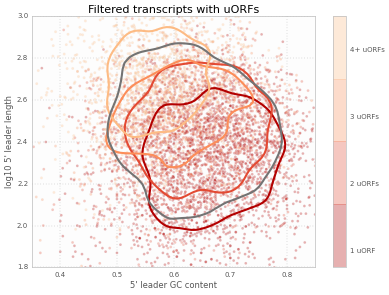

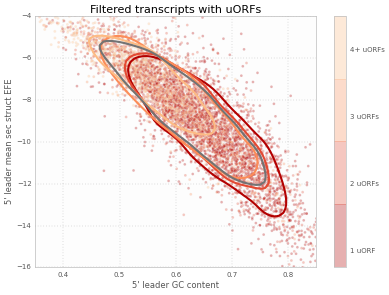

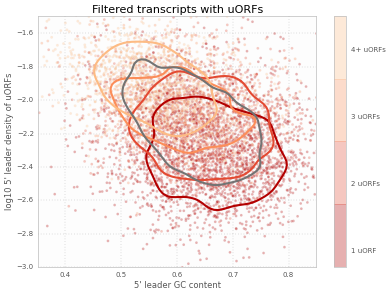

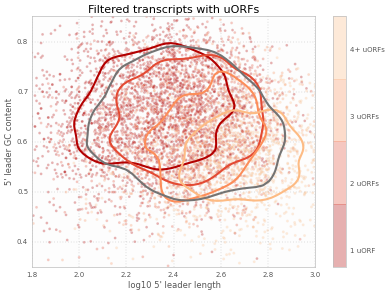

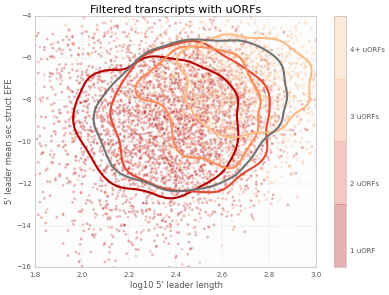

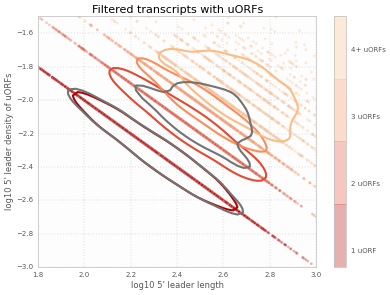

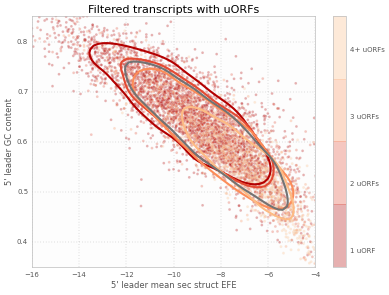

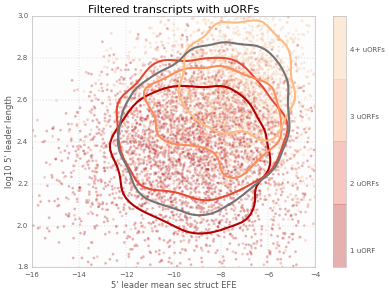

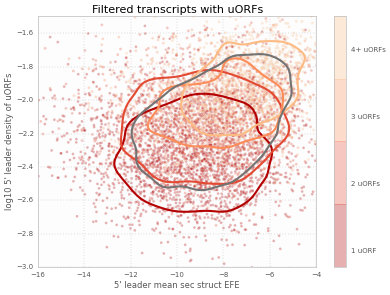

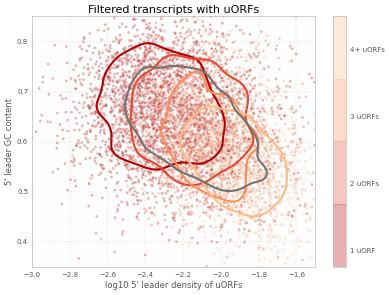

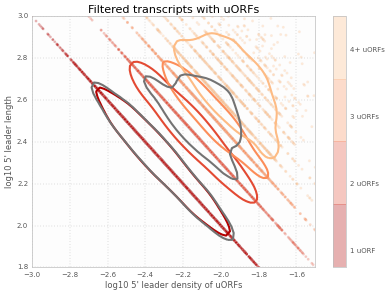

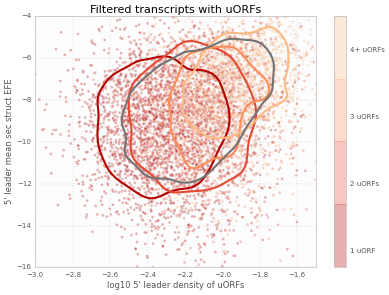

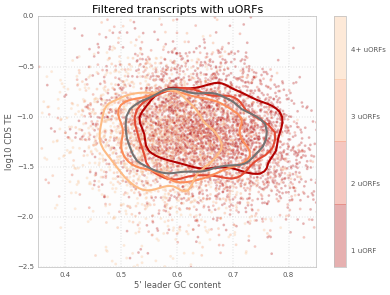

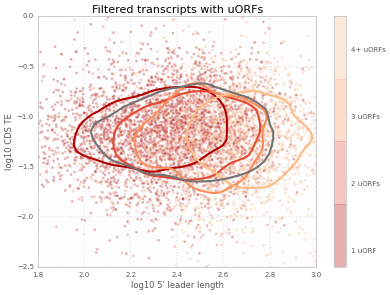

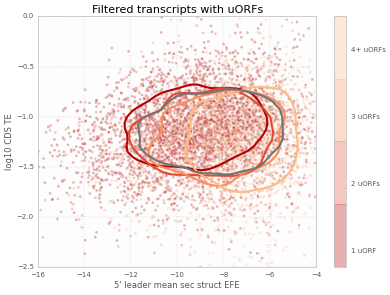

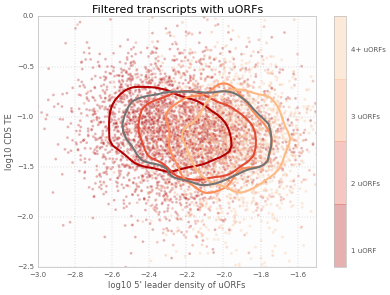

In [29]:
dataset, dataset_label = with_uORFs, "Filtered transcripts with uORFs"
comparisons = [("UTR5_GC", "log_UTR5_length"),
               ("UTR5_GC", "UTR5_mean_ssefe_35"),
               ("UTR5_GC", "log_num_uORFs_density"),
               ("log_UTR5_length", "UTR5_GC"),
               ("log_UTR5_length", "UTR5_mean_ssefe_35"),
               ("log_UTR5_length", "log_num_uORFs_density"),
               ("UTR5_mean_ssefe_35", "UTR5_GC"),
               ("UTR5_mean_ssefe_35", "log_UTR5_length"),
               ("UTR5_mean_ssefe_35", "log_num_uORFs_density"),
               ("log_num_uORFs_density", "UTR5_GC"),
               ("log_num_uORFs_density", "log_UTR5_length"),
               ("log_num_uORFs_density", "UTR5_mean_ssefe_35"),
               ("UTR5_GC", "log_CDS_TE"),
               ("log_UTR5_length", "log_CDS_TE"),
               ("UTR5_mean_ssefe_35", "log_CDS_TE"),
               ("log_num_uORFs_density", "log_CDS_TE")]

for x, y in comparisons:
    scatter_by_uORF_num(dataset, dataset_label, x, y,
                        parameters[x].label, parameters[y].label,
                        parameters[x].limits, parameters[y].limits)